In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import scipy.stats as measures

/home/giulio/prog/.virtualenv/ML/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/giulio/prog/.virtualenv/ML/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/giulio/prog/.virtualenv/ML/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/giulio/prog/.virtualenv/M

In [2]:
tf.reset_default_graph()

In [3]:
df_pm = pd.read_csv("altri_dati/brescia_pm10.csv", names = ["data", "pm"]).iloc[2:]
df_temp = pd.read_csv("altri_dati/brescia_temp.csv")["Valore Medio giornaliero"]
df_umi = pd.read_csv("altri_dati/brescia_umi.csv")["Valore Medio giornaliero"]
df_prec = pd.read_csv("altri_dati/brescia_prec.csv")["Valore Cumulato su 24h"]

In [4]:
#df = df_pm.shift(1)
df = df_pm
df.pm = df.pm.astype(float)
df["temp"] = df_temp.astype(float)
df["umi"] = df_umi.astype(float)
df["prec"] = df_prec.astype(float)
df.index = pd.to_datetime(df.data)
df = df.drop(["data"], axis = 1)
#df["weekend"] = (df.index.weekday > 4) * 1
df["weekday"] = df.index.weekday
df["mese"] = df.index.month

In [5]:
df.replace(-999, np.nan, inplace = True)
df.dropna(inplace = True)

In [6]:
#Pandas risponde con un warning sbagliato ATTENZIONE
if True:
    mov_av = 2
    df["pm"] = df["pm"].rolling(mov_av).mean()
    df = df.iloc[mov_av - 1:]
    df["pm"] = df["pm"].astype(int)

In [7]:
giorno_one_hot = pd.get_dummies(df.weekday)

In [8]:
df = pd.concat([df.drop(["weekday"], axis = 1), giorno_one_hot], axis = 1)

In [9]:
df.head()

,pm,temp,umi,prec,mese,0,1,2,3,4,5,6
data,,,,,,,,,,,,
2018-06-09,19,20.4,70.0,0.0,6,0,0,0,0,0,1,0
2018-06-10,24,17.0,87.0,47.0,6,0,0,0,0,0,0,1
2018-06-11,31,15.9,88.2,2.6,6,1,0,0,0,0,0,0
2018-06-12,31,17.8,73.5,0.0,6,0,1,0,0,0,0,0
2018-06-13,20,17.8,73.2,0.0,6,0,0,1,0,0,0,0


In [10]:
massi_prec = 119.8
mini_temp = -6.6
massi_temp = 32.1

In [11]:
config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )

In [12]:
df.prec = (100 * (df.prec / df.prec.max())).astype(int)
df.temp = (100 * ((df.temp - df.temp.min())/df.temp.max())).astype(int)
df.umi = df.umi.astype(int)

In [13]:
df.head()

,pm,temp,umi,prec,mese,0,1,2,3,4,5,6
data,,,,,,,,,,,,
2018-06-09,19,105,70,0,6,0,0,0,0,0,1,0
2018-06-10,24,90,87,33,6,0,0,0,0,0,0,1
2018-06-11,31,85,88,1,6,1,0,0,0,0,0,0
2018-06-12,31,93,73,0,6,0,1,0,0,0,0,0
2018-06-13,20,93,73,0,6,0,0,1,0,0,0,0


In [14]:
n_steps = 250
n_inputs = len(df.columns)
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = [tf.keras.layers.GRUCell(units = n_neurons, activation = "relu"),
        tf.keras.layers.GRUCell(units = int(n_neurons / 2), activation = "relu"),
        tf.keras.layers.GRUCell(units = int(n_neurons / 3), activation = "relu")
       ]
layer = tf.keras.layers.RNN(cell, dtype=tf.float32, return_state = False, return_sequences = True)(X)
outputs = tf.keras.layers.Dense(1)(layer)
outputs = tf.keras.layers.Reshape((-1, n_outputs))(outputs)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [15]:
saver = tf.train.Saver()

In [16]:
test_X = np.array(df.iloc[-(n_steps + 1):-1].values)
test_Y = np.array(df.pm.iloc[-(n_steps):].values)

with tf.Session(config = config) as sess:
    saver.restore(sess, "./modelli/modello_previsione_post_update_noshift_gru_weekday_onehot")

    X_new = test_X.reshape(1, -1, n_inputs)
    y_pred = sess.run(outputs, feed_dict={X: X_new})

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./modelli/modello_previsione_post_update_noshift_gru_weekday_onehot


In [17]:
test_X.shape

(250, 12)

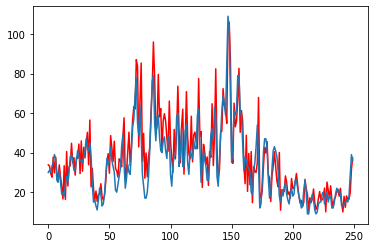

In [18]:
plt.plot(y_pred[0], "r")
plt.plot(test_Y)
plt.show()

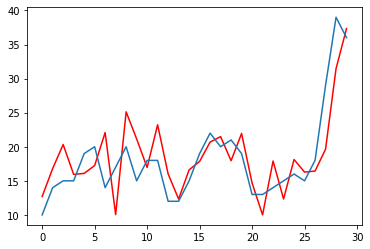

In [19]:
plt.plot(y_pred[0][-30:], "r")
plt.plot(test_Y[-30:])
plt.show()

In [20]:
np.sqrt(mean_squared_error(test_Y, y_pred[0]))

9.713217784080875

In [21]:
np.max(test_Y - y_pred[0])

98.9971399307251

In [22]:
f"Indice di correlazione di Pearson r: {measures.pearsonr(y_pred[0].reshape(-1), test_Y.reshape(-1))[0]}"

'Indice di correlazione di Pearson r: 0.8689025126795792'

In [23]:
f"R-squared: {np.square(measures.pearsonr(y_pred[0].reshape(-1), test_Y.reshape(-1))[0])}"

'R-squared: 0.7549915765408862'

In [24]:
res = y_pred[0].reshape(-1)

In [25]:
f"p-value massimo: {measures.norm.pdf(res, res.mean(), res.std()).max()}"

'p-value massimo: 0.021360375997481508'

In [26]:
f"Valore Z: {(res.mean() - test_Y.mean()) / (test_Y.std() / np.sqrt(test_Y.size))} in una popolazione di {test_Y.size}"

'Valore Z: 2.5933993453904285 in una popolazione di 250'

In [27]:
measures.spearmanr(res, test_Y)

SpearmanrResult(correlation=0.8632191919356785, pvalue=1.4041494624640572e-75)

In [28]:
measures.ttest_rel(res, test_Y)

Ttest_relResult(statistic=4.787467919232887, pvalue=2.8995612137660515e-06)

ANOVA test, l'unico che non passa benissimo, la varianza cambia un po':

In [29]:
measures.f_oneway(res, test_Y)

F_onewayResult(statistic=3.072776272682447, pvalue=0.08022869750119116)

In [30]:
measures.mannwhitneyu(res, test_Y)

MannwhitneyuResult(statistic=28727.0, pvalue=0.05918677566123776)